## Sample MRS acceleration Tutorial

This notebook is a tutorial for a simple implementation on how to create a machine learning model to accelerate GABA Edited-MRS

The model we'll use will receive as input difference transients in the frequency domain and output a single difference spectrum. In other words, it's only performing the denoising and combination of the difference transients. An important note is that this is only one of the possible options, the acceleration could also be done with one model per subspectra, or in the time domain, for example.


In [1]:
# Libraries which we'll use

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

2022-12-15 00:19:52.197211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 00:19:52.317784: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Data Loading

The first thing we'll need to do is loading the data, which is stored as ground truth fids in a numpy file. We'll then add noise to the fids, using the same code as in the `noise_adding_tutorial`, generating our noisy transients this way.

After obtaining the transients, we'll normalize both the x and y data and divide them into training and testing datasets.

In [2]:
## load ground truth data and t array for adding noise

gt_fids = np.load("data/full_ground_truth_fids.npy")
t = np.load("data/t.npy")

# transforming into frequency domain to use as the target data
gt_spec = np.fft.fftshift(np.fft.ifft(gt_fids,axis=1),axes=1)


####  Adding Noise ####
#Expand to new dimension and add 40 transients per subspectra
noise_fid = np.expand_dims(gt_fids.copy(),axis=3)
noise_fid = np.repeat(noise_fid,40,axis=3)

# Amplitude noise
base_amplitude_noise = 10
amplitude_noise = np.random.normal(0,base_amplitude_noise,size=noise_fid.shape)
noise_fid = noise_fid+amplitude_noise

# frequency noise
freq_shift_std=20
freq_shifts = np.random.normal(0,freq_shift_std,size = (noise_fid.shape[0],1,1,noise_fid.shape[3]))
noise_fid = noise_fid*np.exp(1j*(freq_shifts*t.reshape(t.shape[0],t.shape[1],1,1)*math.pi/2))

# phase noise
phase_shift_std=30
phase_shifts = np.random.normal(0,phase_shift_std,size = (noise_fid.shape[0],1,1,noise_fid.shape[3]))
noise_fid = noise_fid*np.exp(1j*(phase_shifts*np.ones((t.shape[0],t.shape[1],1,1))*math.pi/180))
#### Finish Adding Noise ####

# Note: The parameters to add noise and the way noise is added directly affects
# the results and the objective is to be as close as possible to in vivo data.

# Transforming time domain noisy transients into frequency domain difference transients
noise_spec = np.fft.fftshift(np.fft.ifft(noise_fid,axis=1),axes=1)
noise_diff_spec = noise_spec[:,:,1,:]-noise_spec[:,:,0,:]

# initial definition of input and target data
x = np.real(noise_diff_spec)
y = np.real(gt_spec[:,:,1]-gt_spec[:,:,0]) # editing process in subtraction

# normalizing using minimum of region of most interest and total maximum.
x_max = x.max(axis=(1,2),keepdims=True)
x_mean = x[:,900:1100].min(axis=(1,2),keepdims=True)

y_max = y.max(axis=(1),keepdims=True)
y_mean = y[:,900:1100].min(axis=(1),keepdims=True)

x = (x-x_mean)/(x_max-x_mean)
y = (y-y_mean)/(y_max-y_mean)

# expanding dimensions for compatibility with U-NET
x = np.expand_dims(x,axis=3)
y = np.expand_dims(y,axis=(2,3))

# division of training and testing data
x_train = x[:int(x.shape[0]*0.8)]
x_test = x[int(x.shape[0]*0.8):]

y_train = y[:int(y.shape[0]*0.8)]
y_test = y[int(y.shape[0]*0.8):]

### Sample Model Used

In this tutorial, we'll use a simple 2D U-net to combine the transients, considering the transients as a 2D "image" (spectral_points x transients). 

In [3]:
def MRS_unet(input_shape=(2048,40,1)):
    input_layer = tf.keras.layers.Input(shape=input_shape)

    down_conv_1_1 = tf.keras.layers.Conv2D(filters=16,kernel_size=(5,1),padding="same",activation="relu")(input_layer)
    down_conv_1_2 = tf.keras.layers.Conv2D(filters=16,kernel_size=3,padding="same",activation="relu")(down_conv_1_1)
    down_mp_1 = tf.keras.layers.MaxPool2D(pool_size=(2,1))(down_conv_1_2)

    down_conv_2_1 = tf.keras.layers.Conv2D(filters=32,kernel_size=(5,1),padding="same",activation="relu")(down_mp_1)
    down_conv_2_2 = tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="same",activation="relu")(down_conv_2_1)
    down_mp_2 = tf.keras.layers.MaxPool2D(pool_size=(2,1))(down_conv_2_2)

    down_conv_3_1 = tf.keras.layers.Conv2D(filters=64,kernel_size=(5,1),padding="same",activation="relu")(down_mp_2)
    down_conv_3_2 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding="same")(down_conv_3_1)
    down_mp_3 = tf.keras.layers.MaxPool2D(pool_size=(2,1))(down_conv_3_2)

    up_conv_1_1 = tf.keras.layers.Conv2D(filters=128,kernel_size=(5,1),padding="same",activation="relu")(down_mp_3)
    up_conv_1_2 = tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding="same",activation="relu")(up_conv_1_1)
    up_mp_1 = tf.keras.layers.UpSampling2D(size=(2,1))(up_conv_1_2)

    concat_1 = tf.keras.layers.Concatenate(axis=3)([down_conv_3_2,up_mp_1])
    up_conv_2_1 = tf.keras.layers.Conv2D(filters=64,kernel_size=(5,1),padding="same",activation="relu")(concat_1)
    up_conv_2_2 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding="same",activation="relu")(up_conv_2_1)
    up_mp_2 = tf.keras.layers.UpSampling2D(size=(2,1))(up_conv_2_2)

    concat_2 = tf.keras.layers.Concatenate(axis=3)([down_conv_2_2,up_mp_2])
    up_conv_3_1 = tf.keras.layers.Conv2D(filters=32,kernel_size=(5,1),padding="same",activation="relu")(concat_2)
    up_conv_3_2 = tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="same",activation="relu")(up_conv_3_1)
    up_mp_3 = tf.keras.layers.UpSampling2D(size=(2,1))(up_conv_3_2)

    concat_3 = tf.keras.layers.Concatenate(axis=3)([down_conv_1_2,up_mp_3])
    end_conv_1 = tf.keras.layers.Conv2D(filters=128,kernel_size=(1,input_shape[1]),activation="relu")(concat_3)
    end_conv_2 = tf.keras.layers.Conv2D(filters=1,kernel_size=5,padding="same",activation="linear")(end_conv_1)

    model = tf.keras.models.Model(inputs=input_layer, outputs=end_conv_2)
    return model

m = MRS_unet()
m.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 40, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 2048, 40, 16  96          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 2048, 40, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

2022-12-15 00:19:57.260357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 00:19:57.277132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 00:19:57.277436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 00:19:57.278247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFl

Trainable params: 622,321
Non-trainable params: 0
__________________________________________________________________________________________________


### Loss Function and Training

We'll use Mean Absolute Error (MAE) as our loss function, but instead of using it on the whole spectra, we'll only apply the function on a central region containing the GABA peak. This is done to ensure our model works in the region we're interested in, as otherwise the other areas might dominate the loss function and we'll obtain unsatisfying results

In [4]:
# defining loss weights to only consider central region
loss_weights = np.concatenate([0.0*np.ones((912,1)),1*np.ones((150,1)),0.0*np.ones((986,1))],axis=0)

# scheduler for decreasing learning rate
def scheduler(epoch, lr):
            if epoch%10 == 0 and epoch!=0:
                lr = lr/2
            return lr

freq_lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)


# compiling model and training
m.compile(optimizer=tf.keras.optimizers.Adam(), loss="mae",loss_weights = loss_weights)
m.fit(x_train, y_train, batch_size=5, epochs=100, verbose=1, shuffle=True, callbacks=[freq_lr_schedule])


Epoch 1/100


2022-12-15 00:20:01.887529: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


KeyboardInterrupt: 

In [5]:
m.save_weights("weights.h5")

In [5]:
m.load_weights("weights.h5")

### Veryfing Results

We'll now visualize the effects on a single sample from the testing dataset to verify the model is working as expected. We'll also compare to the averaging of input data, to see the effect of the model on the results.

1/1 [==============================] - 0s 13ms/step


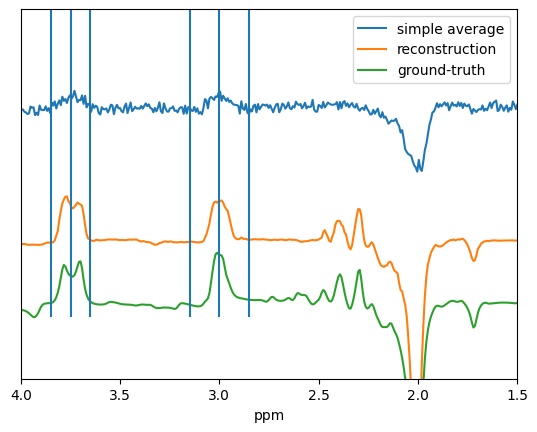

In [75]:
# Comparing results

#loading ppm for plotting
ppm = np.load("data/ppm.npy").flatten()

# choosing scan to view
test_scan=40

# selecting sample
sample_gt_spec = y_test[test_scan]
sample_x_test = x_test[test_scan:test_scan+1]

# calculating simple average of input data
raw_average = sample_x_test.mean(axis=2)

# obtaining output from model
pred = m.predict(sample_x_test)

#plotting all results, with offset between for a better visualization
fig,ax = plt.subplots()

y_offset=0.3

ax.plot(ppm,raw_average.flatten()+2*y_offset,label="simple average")
ax.plot(ppm,pred.flatten()+y_offset,label="reconstruction")
ax.plot(ppm,sample_gt_spec.flatten(),label="ground-truth")


ax.set_ylim(-0.3,1.5)
ax.set_xlim(1.5,4)
ax.set_yticks([])
ax.set_xlabel("ppm")
ax.invert_xaxis()

plt.legend()
plt.show()

In [89]:
def calculate_mse(x,y,ppm):
    # region of interest: 1.5ppm - 4ppm
    max_ind = np.argmin(ppm[ppm<=4])
    min_ind = np.argmax(ppm[ppm>=1.5])

    x_crop = x[:,min_ind:max_ind]
    y_crop = y[:,min_ind:max_ind]

    return (np.square(y_crop-x_crop)).mean(axis=1).mean()

def calculate_snr(x,ppm):
    gaba_max_ind, gaba_min_ind = np.amax(np.where(ppm >= 2.8)), np.amin(np.where(ppm <= 3.2))
    dt_max_ind, dt_min_ind = np.amax(np.where(ppm >= 9.8)), np.amin(np.where(ppm <= 10.8))

    snrs=[]

    for i in range(x.shape[0]):
        spec = x[i]
        max_peak = spec[gaba_min_ind:gaba_max_ind].max()

        dt = np.polyfit(ppm[dt_min_ind:dt_max_ind], spec[dt_min_ind:dt_max_ind], 2)
        sizeFreq = ppm[dt_min_ind:dt_max_ind].shape[0]
        stdev_Man = np.sqrt(np.sum(np.square(np.real(spec[dt_min_ind:dt_max_ind] - np.polyval(dt, ppm[dt_min_ind:dt_max_ind])))) / (sizeFreq - 1))
        
        snrs += [np.real(max_peak) / (2 * stdev_Man)]
    
    return sum(snrs)/len(snrs)

def calculate_linewidth(x,ppm):
    gaba_max_ind, gaba_min_ind = np.amax(np.where(ppm >= 2.8)), np.amin(np.where(ppm <= 3.2))
    linewidths=[]

    for i in range(x.shape[0]):
        spec = x[i,gaba_min_ind:gaba_max_ind]
        #print(spec.shape)
        ##normalizing spec
        spec = (spec-spec.min())/(spec.max()-spec.min())

        max_peak = spec.max()
        #print(max_peak)
        ind_max_peak = np.argmax(spec)
        left_side = spec[:ind_max_peak]
        #print(left_side)
        left_ind = np.amin(np.where(left_side>max_peak/2))+gaba_min_ind
        #print(left_ind)
        right_side = spec[ind_max_peak:]
        #print(right_side)
        right_ind = np.amax(np.where(right_side>max_peak/2))+gaba_min_ind+ind_max_peak
        #print([right_side>max_peak/2])
        #print(right_ind)
        left_ppm = ppm[left_ind]
        right_ppm = ppm[right_ind]

        linewidths.append(left_ppm-right_ppm)
    
    return sum(linewidths)/len(linewidths)

def calculate_shape_score(x,y,ppm):
    gaba_max_ind, gaba_min_ind = np.amax(np.where(ppm >= 2.8)), np.amin(np.where(ppm <= 3.2))
    glx_max_ind, glx_min_ind = np.amax(np.where(ppm >= 3.6)), np.amin(np.where(ppm <= 3.9))

    gaba_corrs=[]
    glx_corrs=[]


    for i in range(0,x.shape[0]):
        gaba_spec_x = x[i,gaba_min_ind:gaba_max_ind]
        gaba_spec_x = (gaba_spec_x-gaba_spec_x.min())/(gaba_spec_x.max()-gaba_spec_x.min())

        gaba_spec_y = y[i,gaba_min_ind:gaba_max_ind]
        gaba_spec_y = (gaba_spec_y-gaba_spec_y.min())/(gaba_spec_y.max()-gaba_spec_y.min())

        gaba_corrs.append(np.corrcoef(gaba_spec_x,gaba_spec_y)[0,1])

        glx_spec_x = x[i,glx_min_ind:glx_max_ind]
        glx_spec_x = (glx_spec_x-glx_spec_x.min())/(glx_spec_x.max()-glx_spec_x.min())

        glx_spec_y = y[i,glx_min_ind:glx_max_ind]
        glx_spec_y = (glx_spec_y-glx_spec_y.min())/(glx_spec_y.max()-glx_spec_y.min())

        glx_corrs.append(np.corrcoef(glx_spec_x,glx_spec_y)[0,1])
    
    gaba_score = sum(gaba_corrs)/len(gaba_corrs)
    glx_score = sum(glx_corrs)/len(glx_corrs)

    return gaba_score*0.6 + glx_score*0.4

def calculate_metrics(x,y,ppm):
    mse = calculate_mse(x,y,ppm)
    snr = calculate_snr(x,ppm)
    linewidth = calculate_linewidth(x,ppm)
    shape_score = calculate_shape_score(x,y,ppm)

    output={
        "mse":mse,
        "snr":snr,
        "linewidth":linewidth,
        "shape_score":shape_score
    }

    return output


In [90]:
## Testing of values


raw_average = x_test[:,:,:,0].mean(axis=2)

# obtaining output from model
pred = m.predict(x_test)[:,:,0,0]


raw_average_score = calculate_metrics(raw_average,y_test[:,:,0,0],ppm)
pred_score = calculate_metrics(pred,y_test[:,:,0,0],ppm)

print(f"Simple Average Score - mse:{raw_average_score['mse']} - snr:{raw_average_score['snr']} - linewidth:{raw_average_score['linewidth']} - shape_score:{raw_average_score['shape_score']}")
print(f"Prediction  Score - mse:{pred_score['mse']} - snr:{pred_score['snr']} - linewidth:{pred_score['linewidth']} - shape_score:{pred_score['shape_score']}")

2/2 [==============================] - 0s 80ms/step
Simple Average Score - mse:0.09907170350840683 - snr:14.398826642319415 - linewidth:0.2686615328307148 - shape_score:0.6926021673747598
Prediction  Score - mse:0.0005096259670798606 - snr:81.428303032422 - linewidth:0.09969682379375434 - shape_score:0.9408820479114917


In [ ]:
# choosing scan to view

# calculating simple average of input data
raw_average = x_test[:,:,:,0].mean(axis=2)

# obtaining output from model
pred = m.predict(x_test)[:,:,0,0]



##compare 
print(calculate_shape_score(raw_average,y_test[:,:,0,0],ppm))
print(calculate_shape_score(pred,y_test[:,:,0,0],ppm))

In [88]:
# choosing scan to view

# calculating simple average of input data
raw_average = x_test[:,:,:,0].mean(axis=2)

# obtaining output from model
pred = m.predict(x_test)[:,:,0,0]



##compare 
print(calculate_shape_score(raw_average,y_test[:,:,0,0],ppm))
print(calculate_shape_score(pred,y_test[:,:,0,0],ppm))

2/2 [==============================] - 0s 81ms/step
0.6926021673747598
0.9408820479114917


In [77]:
# choosing scan to view

# calculating simple average of input data
raw_average = x_test[:,:,:,0].mean(axis=2)

# obtaining output from model
pred = m.predict(x_test)[:,:,0,0]



##compare 
print(calculate_linewidth(raw_average,ppm))
print(calculate_linewidth(pred,ppm))

2/2 [==============================] - 0s 81ms/step
0.2686615328307148
0.09969682379375434


In [8]:
# choosing scan to view

# calculating simple average of input data
raw_average = x_test[:,:,:,0].mean(axis=2)

# obtaining output from model
pred = m.predict(x_test)[:,:,0,0]



##compare 
print(calculate_mse(raw_average,y_test[:,:,0,0],ppm))
print(calculate_mse(pred,y_test[:,:,0,0],ppm))

2/2 [==============================] - 5s 2s/step
0.09907170350840683
0.0005096259670798606


2022-12-15 00:20:45.218027: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
